### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">🌌 Notebook at a glance</p>

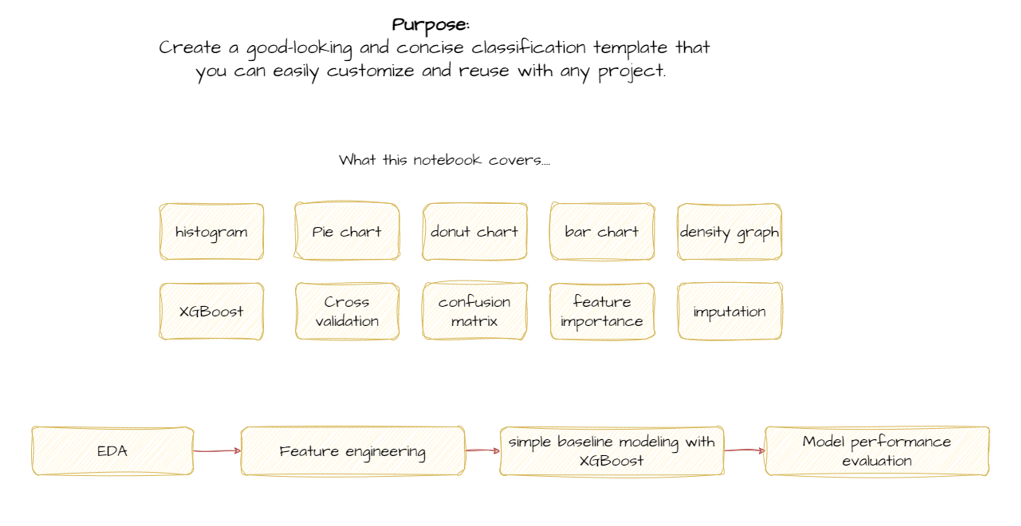

In [ ]:
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re as re
from collections import Counter

from tqdm.auto import tqdm
import math
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')

import time
from xgboost import XGBClassifier
%matplotlib inline
tqdm.pandas()

rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Brief EDA</p>

In [ ]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Data summary:</font></h3>

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [ ]:
# summary table function
pd.options.display.float_format = '{:,.2f}'.format
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [ ]:
summary(train).style.background_gradient(cmap='YlOrBr')

In [ ]:
train.dtypes.value_counts().plot(kind='pie',autopct='%.1f%%')

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* There are missing values in each columns. Therefore, we need to apply imputation methods to fill those missing value in.

In [ ]:
summary(test)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_count(df: pd.core.frame.DataFrame, col_list: list, title_name: str='Train') -> None:
    """Draws the pie and count plots for categorical variables.
    
    Args:
        df (pd.core.frame.DataFrame): A pandas dataframe representing the data to be analyzed. 
            This could be a training set, test set, etc.
        col_list (list): A list of categorical variable column names from 'df' to be analyzed.
        title_name (str): The title of the graph. Default is 'Train'.
        
    Returns:
        None. This function produces pie and count plots of the input data and displays them using matplotlib.
    """

    # Creating subplots with 2 columns for pie and count plots for each variable in col_list
    f, ax = plt.subplots(len(col_list), 2, figsize=(10, 4))
    plt.subplots_adjust(wspace=0)

    for col in col_list:

        # Computing value counts for each category in the column
        s1 = df[col].value_counts()
        N = len(s1)

        outer_sizes = s1
        inner_sizes = s1/N

        # Colors for the outer and inner parts of the pie chart
        outer_colors = ['#9E3F00', '#eb5e00', '#ff781f', '#ff9752', '#ff9752']
        inner_colors = ['#ff6905', '#ff8838', '#ffa66b']

        # Creating outer pie chart
        ax[0].pie(
            outer_sizes, colors=outer_colors, 
            labels=s1.index.tolist(), 
            startangle=90, frame=True, radius=1.3, 
            explode=([0.05]*(N-1) + [.3]),
            wedgeprops={ 'linewidth' : 1, 'edgecolor' : 'white'}, 
            textprops={'fontsize': 12, 'weight': 'bold'},
            shadow=True
        )

        # Text properties for inner pie chart
        textprops = {
            'size':13, 
            'weight': 'bold', 
            'color':'white'
        }

        # Creating inner pie chart
        ax[0].pie(
            inner_sizes, colors=inner_colors,
            radius=1, startangle=90,
            autopct='%1.f%%', explode=([.1]*(N-1) + [.3]),
            pctdistance=0.8, textprops=textprops,
            shadow=True
        )

        # Creating a white circle at the center
        center_circle = plt.Circle((0,0), .68, color='black', 
                                fc='white', linewidth=0)
        ax[0].add_artist(center_circle)

        # Barplot for the count of each category in the column
        sns.barplot(
            x=s1, y=s1.index, ax=ax[1],
            palette='YlOrBr_r', orient='horizontal'
        )

        # Customizing the bar plot
        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        ax[1].tick_params(
            axis='x',         
            which='both',      
            bottom=False,      
            labelbottom=False
        )

        # Adding count values at the end of each bar
        for i, v in enumerate(s1):
            ax[1].text(v, i+0.1, str(v), color='black', 
                        fontweight='bold', fontsize=12)

        # Adding labels and title
        plt.setp(ax[1].get_yticklabels(), fontweight="bold")
        plt.setp(ax[1].get_xticklabels(), fontweight="bold")
        ax[1].set_xlabel(col, fontweight="bold", color='black')
        ax[1].set_ylabel('count', fontweight="bold", color='black')

    # Setting a global title for all subplots
    f.suptitle(f'{title_name} Dataset', fontsize=20, fontweight='bold')

    # Adjusting the spacing between the plots
    plt.tight_layout()    
    plt.show()


In [ ]:
plot_count(train, ['Transported'], 'Train')

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* This is a balanced dataset!

In [ ]:
exp_cols = ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]
# num_data = train_data.select_dtypes(exclude=['object']).copy()

plt.figure(figsize=(14,10))
for idx,column in enumerate(exp_cols):
    plt.subplot(3,2,idx+1)
    sns.histplot(x=column, hue="Transported", data=train,bins=30,kde=True,palette='YlOrRd')
    plt.title(f"{column} Distribution")
    plt.ylim(0,100)
    plt.tight_layout()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* Numerical variables are not normally distributed. (skewed)
* Distribution between 'False' and 'True' is quite different in each variables, which means these variables have predictive power.

In [ ]:
cat_cols = ["HomePlanet","CryoSleep","Destination","VIP"]

plt.figure(figsize=(14,9))
for idx,column in enumerate(cat_cols):
    plt.subplot(2,2,idx+1)
    sns.countplot(x=column, hue="Transported", data=train, palette="YlOrRd")
    plt.title(f"{column} Distribution")
    plt.tight_layout()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* HomePlanet- The most of passenger are from Earth but passenger from Earth are Comparatively Less Transported, passenger from Mars are Equally Transported, and passengers from Europa are Highly Transported.
* Cryosleep - cryosleep people shows better transport percentage than non cryosleep people.
* Trappist-1e has greate no of transported people but if we see who has better %of tranported people I will sayits 55 cancrie
* Vip- Non Vip person has Equal chance of being on either side. However Vip has more than half the chance that they will not transported. Money Matters here!!!!


In [ ]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str='Train correlation') -> None:

    corr = df.corr()
    fig, axes = plt.subplots(figsize=(12, 8))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='YlOrBr_r', annot=True)
    plt.title(title_name)
    plt.show()


plot_correlation_heatmap(train, 'Train Dataset Correlation')


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* No strong correlations between varaibles.

In [ ]:
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

def perform_hierarchical_clustering(input_data, title):
    """
    Function to perform hierarchical clustering and visualize the clusters in the form of a dendrogram.

    Args:
        input_data (pd.core.frame.DataFrame): The data on which to perform hierarchical clustering.
        title (str): The title for the plot.

    Returns:
        None. Displays a dendrogram plot.
    """
    # Create a new figure and set the size and resolution
    fig, ax = plt.subplots(1, 1, figsize=(14, 8), dpi=120)

    # Compute the correlation matrix of the input data
    correlation_matrix = input_data.corr()

    # Convert the correlation matrix to distances
    distance_matrix = 1 - np.abs(correlation_matrix)

    # Perform hierarchical clustering using the "complete" method
    # The "complete" method considers the distance between two clusters to be the maximum distance between their elements
    Z = linkage(squareform(distance_matrix), 'complete')
    
    # Plot the dendrogram
    # The dendrogram represents the nested clustering that is performed by the hierarchical clustering
    # Each node in the dendrogram represents a cluster
    # The y-axis represents the distance (or dissimilarity) between clusters
    # The x-axis represents the labels for each data point
    # Clusters that are under the red line are the final clusters
    # Clusters that are under the green line are formed at a lower distance, hence, they are not considered as final clusters
    dn = dendrogram(Z, labels=input_data.columns, ax=ax, above_threshold_color='#ff0000', orientation='right', color_threshold=0.7*max(Z[:,2]))
    hierarchy.set_link_color_palette(None)  # Reset color palette to default

    # Add gridlines to the plot for better readability
    plt.grid(axis='x')

    # Set the title of the plot
    plt.title(f'{title} Hierarchical clustering, Dendrogram', fontsize=18, fontweight='bold')

    # Display the plot
    plt.show()

# Perform hierarchical clustering on numerical of train dataset
perform_hierarchical_clustering(train[["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]], title='Train data')


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* In the dendrogram, the height of the horizontal lines (and the distance between clusters) indicates the dissimilarity between clusters. The color of the lines indicates at what point clusters are formed. The red line shows the final clusters that are formed at a higher distance. Clusters that are under the green line are formed at a lower distance, hence, they are not considered as final clusters. The x-axis labels represent the labels for each data point.

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Data Preprocessing</p>

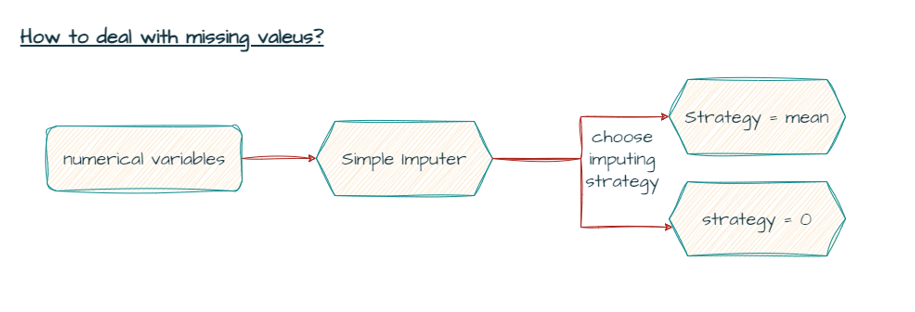

In [ ]:
#make a list of numerical variables
num_cols = test.select_dtypes(exclude=['object']).columns.tolist()

In [ ]:
# choose strategy = 'mean'
# you can change it to zero or other inputation methods.
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan,
                        strategy ='mean')
train[num_cols] = imputer.fit_transform(train[num_cols])
test[num_cols] = imputer.fit_transform(test[num_cols])

> ##### ℹ️ Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

In [ ]:
train['Cabin']

In [ ]:
# split by '/' and expand it to three columns respectively
train[['Deck', 'Num', 'Side']] = test['Cabin'].str.split('/', expand=True)   
test[['Deck', 'Num', 'Side']] = test['Cabin'].str.split('/', expand=True)   

In [ ]:
# manually transform missing values in each new columns
train['Deck']= train['Deck'].fillna('F')
train['Num'] = train['Num'].astype(float)
train['Num']= train['Num'].fillna(train['Num'].mean())
train['Side']= train['Side'].fillna('S')

test['Deck']= test['Deck'].fillna('F')
test['Num'] = test['Num'].astype(float)
test['Num']= test['Num'].fillna(test['Num'].mean())
test['Side']= test['Side'].fillna('S')

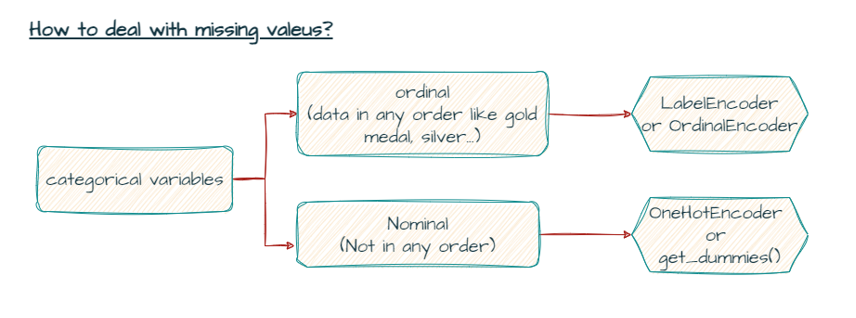

In [ ]:
ONE_HOT_CATEGORICAL = ['HomePlanet', 'Destination', 'Side', 'CryoSleep','VIP']
def create_one_hot(df, categ_colums = ONE_HOT_CATEGORICAL):
    """
    Creates one_hot encoded fields for the specified categorical columns...
    Args
        df
        categ_colums
    Returns
        df
    """
    df = pd.get_dummies(df, columns=categ_colums)
    return df

LABEL_CATEGORICAL = ['Deck']
def encode_categ_features(df, categ_colums = LABEL_CATEGORICAL):
    """
    Use the label encoder to encode categorical features...
    Args
        df
        categ_colums
    Returns
        df
    """
    le = LabelEncoder()
    for col in categ_colums:
        df['enc_'+col] = le.fit_transform(df[col])
    df.drop(categ_colums, axis=1, inplace=True)
    return df

train = encode_categ_features(train)
test = encode_categ_features(test)

train = create_one_hot(train)
test = create_one_hot(test)

In [ ]:
train.drop(['PassengerId','Cabin', 'Name'], axis=1, inplace=True)
#keep passengerId for submission 
PassengerId = test['PassengerId']
test.drop(['PassengerId','Cabin', 'Name'], axis=1, inplace=True)


In [ ]:
train.head()

In [ ]:
# label encoding y(target) variable
train.Transported=train.Transported.map(int)

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Simple baseline modeling</p>

In [ ]:
def f_importance_plot(f_imp):
    fig = plt.figure(figsize=(12, 0.20*len(f_imp)))
    plt.title('Feature importances', size=16, y=1.05, 
              fontweight='bold', color='#444444')
    a = sns.barplot(data=f_imp, x='avg_imp', y='feature', 
                    palette='YlOrBr_r', linestyle="-", 
                    linewidth=0.5, edgecolor="black")
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(size=11, color='#444444')
    
    for j in ['right', 'top', 'bottom']:
        a.spines[j].set_visible(False)
    for j in ['left']:
        a.spines[j].set_linewidth(0.5)
    plt.tight_layout()
    plt.show()
    
def show_confusion_roc(oof: list) -> None:
    """Draws a confusion matrix and roc_curve with AUC score.
        
        Args:
            oof: predictions for each fold stacked. (list of tuples)
        
        Returns:
            None
    """
    
    f, ax = plt.subplots(1, 2, figsize=(13.3, 4))
    df = pd.DataFrame(np.concatenate(oof), columns=['id', 'preds', 'target']).set_index('id')
    df.index = df.index.astype(int)
    cm = confusion_matrix(df.target, df.preds.ge(0.5).astype(int))
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r', ax=ax[0])
    ax[0].grid(False)
    RocCurveDisplay.from_predictions(df.target, df.preds, color='#20BEFF', ax=ax[1])
    plt.tight_layout();
    
def get_mean_auc(oof: np.array):
    """oof: ['val_idx', 'preds', 'target']"""
    oof = pd.DataFrame(np.concatenate(oof), columns=['id', 'preds', 'target']).set_index('id')
    oof.index = oof.index.astype(int)
    mean_val_auc = roc_auc_score(oof.target, oof.preds)
    return mean_val_auc

In [ ]:
#reference: https://www.kaggle.com/code/sergiosaharovskiy/ps-s3e7-2023-eda-and-submission
FOLDS = 10
SEED = 1004
xgb_models = []
xgb_oof = []
predictions = np.zeros(len(test))
f_imp = []

counter = 1
X = train.drop(columns=['Transported'])
y = train.Transported
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    if (fold + 1)%5 == 0 or (fold + 1) == 1:
        print(f'{"#"*24} Training FOLD {fold+1} {"#"*24}')
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
    watchlist = [(X_train, y_train), (X_valid, y_valid)]

    # XGboost model and fit
    model = XGBClassifier(n_estimators=1000, n_jobs=-1, max_depth=4, eta=0.2, colsample_bytree=0.67)
    model.fit(X_train, y_train, eval_set=watchlist, early_stopping_rounds=300, verbose=0)

    val_preds = model.predict_proba(X_valid)[:, 1]
    val_score = roc_auc_score(y_valid, val_preds)
    best_iter = model.best_iteration

    idx_pred_target = np.vstack([val_idx,  val_preds, y_valid]).T # shape(len(val_idx), 3)
    f_imp.append({i: j for i in model.feature_names_in_ for j in model.feature_importances_ })
    print(f'{" "*20} auc:{blu}{val_score:.5f}{res} {" "*6} best iteration  :{blu}{best_iter}{res}')

    xgb_oof.append(idx_pred_target)
    xgb_models.append(model)
#     test_preds = model.predict_proba(test)[:,1] / FOLDS
#     predictions += test_preds
    if val_score > 0.80:
        test_preds = model.predict_proba(test)[:,1] 
        predictions += test_preds
        counter += 1

predictions /= counter
mean_val_auc = get_mean_auc(xgb_oof)
print('*'*45)
print(f'{red}Mean{res} AUC: {red}{mean_val_auc:.5f}{res}')

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Evaluation</p>

In [ ]:
#reference: https://www.kaggle.com/code/sergiosaharovskiy/ps-s3e7-2023-eda-and-submission
show_confusion_roc(xgb_oof)
f_imp_df = pd.DataFrame(f_imp).mean().reset_index()
f_imp_df.columns = ['feature', 'avg_imp']
f_importance_plot(f_imp_df)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Conclusion:</font></h3>

* I skipped detailed feature engineering and hyper-parameter tuning, which could enhance model performance.

* You can apply this template to almost every classification problem.

#### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Acknowledgement</p>

* preprocessing: https://www.kaggle.com/code/minhajulhoque/ensemble-xgboost-for-spaceship-titanic-with-80-4

* Modeling and evaluation code: https://www.kaggle.com/code/sergiosaharovskiy/ps-s3e7-2023-eda-and-submission

* @jcaliz for .css and plotting ideas.